# Simulazione del Rumore con Qiskit Aer

**Course**: Quantum Computing Laboratory  
**Version**: 2.2 (Qiskit 2.2 Compatible)  
**Last Updated**: December 2025

---

## Indice

1. [Introduzione al Rumore Quantistico](#intro)
2. [Tipi di Errori Quantistici](#error_types)
3. [Costruzione di un Noise Model](#noise_model)
4. [Errori Depolarizzanti](#depolarizing)
5. [Rilassamento Termico (T1/T2)](#thermal)
6. [Errori di Misura (Readout)](#readout)
7. [Noise Model Completo](#complete)
8. [Noise Model da Backend Reale](#from_backend)
9. [Caso Studio: Algoritmo di Grover](#grover)
10. [Esercizi](#exercises)

<a id='intro'></a>
## 1. Introduzione al Rumore Quantistico

### Perche il rumore e importante?

I computer quantistici reali sono affetti da **rumore** che degrada la qualita dei calcoli. Le principali fonti sono:

| Fonte | Descrizione | Scala temporale |
|-------|-------------|------------------|
| **Decoerenza** | Perdita di informazione quantistica | T1 ~ 100 us, T2 ~ 80 us |
| **Errori di gate** | Imperfezioni nelle operazioni | ~0.1% (1q), ~1% (2q) |
| **Errori di misura** | Lettura errata dello stato | ~1-5% |
| **Crosstalk** | Interferenza tra qubit | Dipende dalla topologia |

### Obiettivo del notebook

Imparare a:
1. Modellare diversi tipi di rumore
2. Costruire noise model personalizzati
3. Simulare circuiti con rumore realistico
4. Analizzare l'impatto del rumore sulle prestazioni

In [1]:
# Imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

# Noise modeling imports
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
    phase_damping_error,
    amplitude_damping_error
)

import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

print("Qiskit Aer Noise Simulation ready")

Qiskit Aer Noise Simulation ready


<a id='error_types'></a>
## 2. Tipi di Errori Quantistici

### 2.1 Errori Coerenti vs Incoerenti

**Errori coerenti**: Rotazioni sistematiche (es. over-rotation di un gate)
- Possono essere corretti con calibrazione
- Esempio: RZ(theta + epsilon) invece di RZ(theta)

**Errori incoerenti**: Processi stocastici che degradano lo stato
- Richiedono error correction/mitigation
- Esempio: depolarizing, amplitude damping

### 2.2 Canali Quantistici

Gli errori incoerenti sono descritti come **canali quantistici** (completely positive trace-preserving maps):

$$\mathcal{E}(\rho) = \sum_k E_k \rho E_k^\dagger$$

dove $\{E_k\}$ sono gli **operatori di Kraus** che soddisfano $\sum_k E_k^\dagger E_k = I$.

### 2.3 Errori Principali

| Errore | Operatori Kraus | Effetto fisico |
|--------|-----------------|----------------|
| Bit flip | sqrt(1-p)I, sqrt(p)X | 0 <-> 1 |
| Phase flip | sqrt(1-p)I, sqrt(p)Z | + <-> - |
| Depolarizing | Mix con stato massimamente misto | Perdita di purezza |
| Amplitude damping | Decadimento 1 -> 0 | Rilassamento T1 |
| Phase damping | Perdita di fase | Dephasing T2 |

In [2]:
# Visualizzazione effetto degli errori su uno stato |+>
def simulate_error_effect(error, n_shots: int = 10000) -> dict:
    """Simula l'effetto di un errore sullo stato |+>."""
    qc = QuantumCircuit(1, 1)
    qc.h(0)  # Prepara |+>
    qc.measure(0, 0)
    
    # Noise model con errore dopo H
    noise = NoiseModel()
    noise.add_all_qubit_quantum_error(error, ['h'])
    
    sim = AerSimulator(noise_model=noise)
    sampler = SamplerV2()
    sampler._backend = sim
    
    job = sampler.run([qc], shots=n_shots)
    counts = job.result()[0].data.c.get_counts()
    
    return counts

# Test: stato |+> ideale (50-50)
print("Effetto di diversi errori su |+>:")
print("=" * 50)

# Nessun errore (reference)
qc_ref = QuantumCircuit(1, 1)
qc_ref.h(0)
qc_ref.measure(0, 0)
sim_ideal = AerSimulator()
sampler_ideal = SamplerV2()
job_ideal = sampler_ideal.run([qc_ref], shots=10000)
counts_ideal = job_ideal.result()[0].data.c.get_counts()
print(f"Ideale: {counts_ideal}")

# Bit flip con p=10%
bit_flip = pauli_error([('X', 0.1), ('I', 0.9)])
counts_bf = simulate_error_effect(bit_flip)
print(f"Bit flip (p=10%): {counts_bf}")

# Phase flip con p=10%
phase_flip = pauli_error([('Z', 0.1), ('I', 0.9)])
counts_pf = simulate_error_effect(phase_flip)
print(f"Phase flip (p=10%): {counts_pf}")

# Depolarizing con p=10%
depol = depolarizing_error(0.1, 1)
counts_dep = simulate_error_effect(depol)
print(f"Depolarizing (p=10%): {counts_dep}")

Effetto di diversi errori su |+>:
Ideale: {'1': 5019, '0': 4981}
Bit flip (p=10%): {'1': 5014, '0': 4986}
Phase flip (p=10%): {'0': 4957, '1': 5043}
Depolarizing (p=10%): {'0': 4948, '1': 5052}


<a id='noise_model'></a>
## 3. Costruzione di un Noise Model

### Struttura di un NoiseModel

Un `NoiseModel` in Qiskit Aer contiene:
1. **Quantum errors**: Errori applicati dopo i gate
2. **Readout errors**: Errori di misura
3. **Basis gates**: Gate supportati dal modello

In [3]:
# Creiamo un noise model passo per passo
noise_model = NoiseModel()

print("Costruzione di un NoiseModel")
print("=" * 50)

# 1. Errore su gate 1-qubit (tutti i qubit)
error_1q = depolarizing_error(0.001, 1)  # 0.1% errore
noise_model.add_all_qubit_quantum_error(error_1q, ['h', 'x', 'y', 'z', 'rx', 'ry', 'rz'])
print("Aggiunto errore 0.1% su gate 1-qubit")

# 2. Errore su gate 2-qubit (tutti i qubit)
error_2q = depolarizing_error(0.01, 2)  # 1% errore
noise_model.add_all_qubit_quantum_error(error_2q, ['cx', 'cz', 'cp'])
print("Aggiunto errore 1% su gate 2-qubit")

# 3. Errore di misura
p_meas_error = 0.02  # 2% errore
readout_error = ReadoutError([[1 - p_meas_error, p_meas_error],
                               [p_meas_error, 1 - p_meas_error]])
noise_model.add_all_qubit_readout_error(readout_error)
print("Aggiunto errore di misura 2%")

# Visualizza il noise model
print(f"\nNoise Model summary:")
print(f"  Basis gates: {noise_model.basis_gates}")
print(f"  Noise instructions: {noise_model.noise_instructions}")
print(f"  Noise qubits: {noise_model.noise_qubits}")

Costruzione di un NoiseModel
Aggiunto errore 0.1% su gate 1-qubit
Aggiunto errore 1% su gate 2-qubit
Aggiunto errore di misura 2%

Noise Model summary:
  Basis gates: ['cp', 'cx', 'cz', 'h', 'id', 'rx', 'ry', 'rz', 'sx', 'x', 'y', 'z']
  Noise instructions: ['cp', 'cx', 'cz', 'h', 'measure', 'rx', 'ry', 'rz', 'x', 'y', 'z']
  Noise qubits: []


In [4]:
# Confronto: circuito ideale vs rumoroso
def compare_ideal_noisy(circuit: QuantumCircuit, noise: NoiseModel,
                        shots: int = 4096) -> Tuple[dict, dict]:
    """
    Confronta esecuzione ideale e rumorosa.
    
    Returns:
        (counts_ideal, counts_noisy)
    """
    # Simulatore ideale
    sim_ideal = AerSimulator()
    sampler_ideal = SamplerV2()
    pm = generate_preset_pass_manager(optimization_level=1, backend=sim_ideal)
    transpiled = pm.run(circuit)
    
    job_ideal = sampler_ideal.run([transpiled], shots=shots)
    
    # Estrai il nome del registro classico
    creg_name = circuit.cregs[0].name if circuit.cregs else 'c'
    counts_ideal = job_ideal.result()[0].data.__getattribute__(creg_name).get_counts()
    
    # Simulatore rumoroso
    sim_noisy = AerSimulator(noise_model=noise)
    sampler_noisy = SamplerV2()
    sampler_noisy._backend = sim_noisy
    
    job_noisy = sampler_noisy.run([transpiled], shots=shots)
    counts_noisy = job_noisy.result()[0].data.__getattribute__(creg_name).get_counts()
    
    return counts_ideal, counts_noisy

# Test: Bell state
qc_bell = QuantumCircuit(2, 2, name='Bell')
qc_bell.h(0)
qc_bell.cx(0, 1)
qc_bell.measure([0, 1], [0, 1])

ideal, noisy = compare_ideal_noisy(qc_bell, noise_model)

print("Bell State: |00> + |11>")
print(f"  Ideale: {ideal}")
print(f"  Rumoroso: {noisy}")

# Calcola fidelity approssimata
total = sum(noisy.values())
correct = noisy.get('00', 0) + noisy.get('11', 0)
fidelity = correct / total
print(f"  Fidelity approssimata: {fidelity:.4f}")

Bell State: |00> + |11>
  Ideale: {'11': 2035, '00': 2061}
  Rumoroso: {'11': 1893, '00': 2022, '01': 95, '10': 86}
  Fidelity approssimata: 0.9558


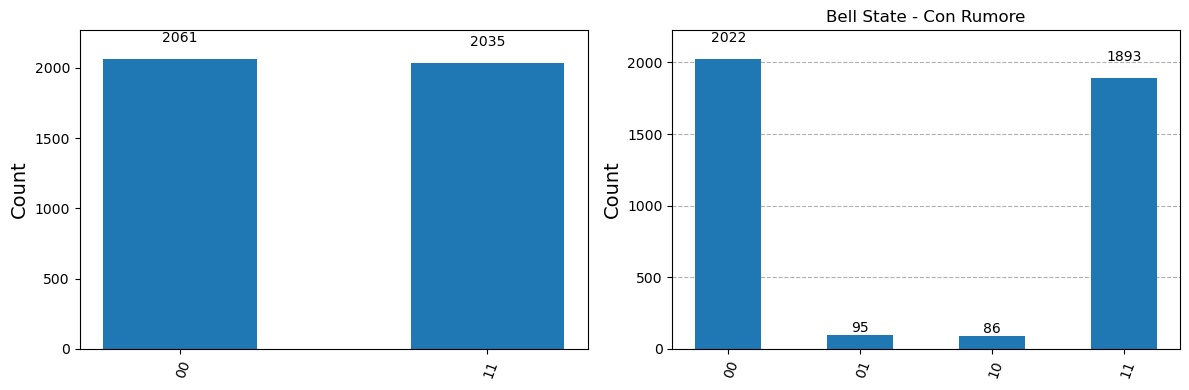

In [5]:
# Visualizzazione
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plot_histogram(ideal, ax=ax1, title='Bell State - Ideale')
plot_histogram(noisy, ax=ax2, title='Bell State - Con Rumore')

plt.tight_layout()
plt.show()

<a id='depolarizing'></a>
## 4. Errori Depolarizzanti

### Definizione

L'errore depolarizzante "mescola" lo stato con lo stato massimamente misto:

$$\mathcal{E}_{dep}(\rho) = (1-p)\rho + \frac{p}{d}I$$

Per 1 qubit ($d=2$):
$$\mathcal{E}_{dep}(\rho) = (1-p)\rho + \frac{p}{3}(X\rho X + Y\rho Y + Z\rho Z)$$

Per 2 qubit ($d=4$):
$$\mathcal{E}_{dep}(\rho) = (1-p)\rho + \frac{p}{15}\sum_{P} P\rho P$$

In [6]:
def study_depolarizing_effect(p_range: List[float], circuit: QuantumCircuit,
                               expected_states: List[str]) -> dict:
    """
    Studia l'effetto dell'errore depolarizzante al variare di p.
    
    Args:
        p_range: Lista di probabilita di errore
        circuit: Circuito da testare
        expected_states: Stati attesi (per calcolare fidelity)
    
    Returns:
        Dizionario con fidelity per ogni p
    """
    results = {'p': [], 'fidelity': []}
    creg_name = circuit.cregs[0].name
    
    for p in p_range:
        # Crea noise model
        noise = NoiseModel()
        noise.add_all_qubit_quantum_error(depolarizing_error(p, 1), ['h', 'x'])
        noise.add_all_qubit_quantum_error(depolarizing_error(p, 2), ['cx'])
        
        # Simula
        sim = AerSimulator(noise_model=noise)
        sampler = SamplerV2()
        sampler._backend = sim
        
        job = sampler.run([circuit], shots=4096)
        counts = job.result()[0].data.__getattribute__(creg_name).get_counts()
        
        # Calcola fidelity
        total = sum(counts.values())
        correct = sum(counts.get(s, 0) for s in expected_states)
        fidelity = correct / total
        
        results['p'].append(p)
        results['fidelity'].append(fidelity)
    
    return results

# Studio per Bell state
p_values = [0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3]
bell_results = study_depolarizing_effect(p_values, qc_bell, ['00', '11'])

print("Effetto depolarizzante su Bell state:")
print(f"{'p':>8} {'Fidelity':>10}")
print("-" * 20)
for p, f in zip(bell_results['p'], bell_results['fidelity']):
    print(f"{p:>8.2f} {f:>10.4f}")

Effetto depolarizzante su Bell state:
       p   Fidelity
--------------------
    0.00     1.0000
    0.01     0.9941
    0.02     0.9907
    0.05     0.9736
    0.10     0.9502
    0.15     0.9231
    0.20     0.9048
    0.30     0.8518


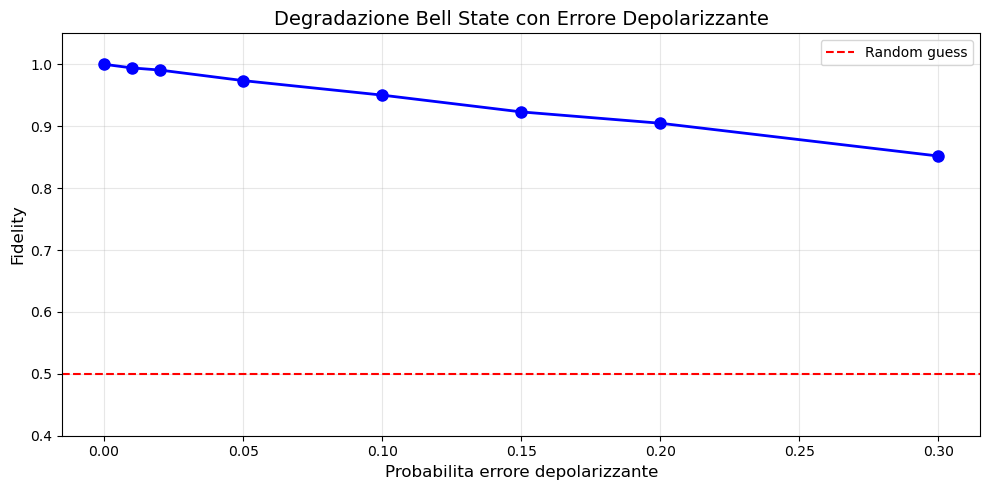

In [7]:
# Grafico fidelity vs errore depolarizzante
plt.figure(figsize=(10, 5))

plt.plot(bell_results['p'], bell_results['fidelity'], 'bo-', linewidth=2, markersize=8)
plt.axhline(y=0.5, color='r', linestyle='--', label='Random guess')

plt.xlabel('Probabilita errore depolarizzante', fontsize=12)
plt.ylabel('Fidelity', fontsize=12)
plt.title('Degradazione Bell State con Errore Depolarizzante', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0.4, 1.05)

plt.tight_layout()
plt.show()

<a id='thermal'></a>
## 5. Rilassamento Termico (T1/T2)

### Fisica del rilassamento

**T1 (Rilassamento longitudinale)**: Decadimento di |1> verso |0>
- Causa: Emissione spontanea, interazione con l'ambiente
- Effetto: |1> -> |0> con probabilita 1 - exp(-t/T1)

**T2 (Dephasing)**: Perdita della coerenza di fase
- Causa: Fluttuazioni del campo magnetico locale
- Effetto: |+> -> stato misto
- Relazione: T2 <= 2*T1 (limite fisico)

In [8]:
def create_thermal_noise_model(t1: float, t2: float, 
                                gate_times: dict = None) -> NoiseModel:
    """
    Crea un noise model con rilassamento termico.
    
    Args:
        t1: Tempo T1 in nanosecondi
        t2: Tempo T2 in nanosecondi (deve essere <= 2*T1)
        gate_times: Dizionario {gate_name: time_ns}
    
    Returns:
        NoiseModel configurato
    """
    if gate_times is None:
        # Tempi tipici per hardware superconduttore
        gate_times = {
            'h': 35,      # ~35 ns
            'x': 35,
            'y': 35,
            'z': 0,       # Virtuale (nessun tempo)
            'rx': 35,
            'ry': 35,
            'rz': 0,
            'cx': 300,    # ~300 ns (gate 2q piu lento)
            'cz': 300,
            'measure': 1000  # ~1 us
        }
    
    noise = NoiseModel()
    
    # Aggiungi errore termico per ogni tipo di gate
    for gate, time in gate_times.items():
        if time > 0:
            if gate in ['cx', 'cz', 'cp']:
                # Gate 2-qubit: applica errore termico a entrambi i qubit
                error = thermal_relaxation_error(t1, t2, time).tensor(
                        thermal_relaxation_error(t1, t2, time))
                noise.add_all_qubit_quantum_error(error, [gate])
            else:
                # Gate 1-qubit
                error = thermal_relaxation_error(t1, t2, time)
                noise.add_all_qubit_quantum_error(error, [gate])
    
    return noise

# Crea noise model con T1=100us, T2=80us (valori realistici)
T1 = 100e3  # 100 us in ns
T2 = 80e3   # 80 us in ns

thermal_noise = create_thermal_noise_model(T1, T2)

print(f"Noise Model con Rilassamento Termico")
print(f"  T1 = {T1/1000:.0f} us")
print(f"  T2 = {T2/1000:.0f} us")

Noise Model con Rilassamento Termico
  T1 = 100 us
  T2 = 80 us


In [9]:
# Studio dell'effetto di T1 su |1>
def study_t1_decay(t1_values: List[float], circuit_depth: int = 100) -> dict:
    """
    Studia il decadimento T1 di |1> al variare di T1.
    """
    results = {'t1': [], 'p_survive': []}
    
    # Circuito: prepara |1> e applica identita (per accumulare tempo)
    qc = QuantumCircuit(1, 1)
    qc.x(0)  # Prepara |1>
    for _ in range(circuit_depth):
        qc.id(0)  # Identita (ma accumula tempo di decoerenza)
    qc.measure(0, 0)
    
    for t1 in t1_values:
        # Noise model
        noise = NoiseModel()
        # 50 ns per identity gate (simula il tempo di idle)
        error = thermal_relaxation_error(t1, t1, 50)  # T2=T1 per semplicita
        noise.add_all_qubit_quantum_error(error, ['id', 'x'])
        
        sim = AerSimulator(noise_model=noise)
        sampler = SamplerV2()
        sampler._backend = sim
        
        job = sampler.run([qc], shots=4096)
        counts = job.result()[0].data.c.get_counts()
        
        total = sum(counts.values())
        p_1 = counts.get('1', 0) / total
        
        results['t1'].append(t1)
        results['p_survive'].append(p_1)
    
    return results

# Studio con diversi T1
t1_range = [1e3, 5e3, 10e3, 20e3, 50e3, 100e3, 200e3]  # ns
t1_results = study_t1_decay(t1_range, circuit_depth=100)

print("Decadimento T1 (|1> survival probability):")
print(f"{'T1 (us)':>10} {'P(|1>)':>10}")
print("-" * 22)
for t1, p in zip(t1_results['t1'], t1_results['p_survive']):
    print(f"{t1/1000:>10.0f} {p:>10.4f}")

Decadimento T1 (|1> survival probability):
   T1 (us)     P(|1>)
----------------------
         1     0.0046
         5     0.3669
        10     0.6016
        20     0.7551
        50     0.9058
       100     0.9551
       200     0.9705


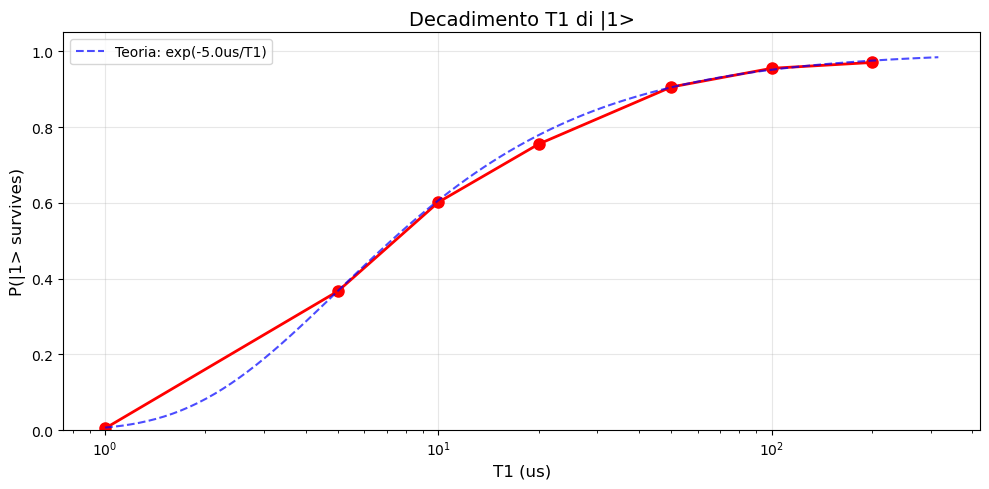

In [10]:
# Grafico decadimento T1
plt.figure(figsize=(10, 5))

t1_us = [t/1000 for t in t1_results['t1']]
plt.semilogx(t1_us, t1_results['p_survive'], 'ro-', linewidth=2, markersize=8)

# Linea teorica: P = exp(-t_circuit/T1)
t_circuit = 100 * 50  # 100 identity gates x 50 ns
t1_theory = np.logspace(0, 2.5, 100) * 1000  # 1 us to ~300 us in ns
p_theory = np.exp(-t_circuit / t1_theory)
plt.semilogx([t/1000 for t in t1_theory], p_theory, 'b--', 
             label=f'Teoria: exp(-{t_circuit/1000:.1f}us/T1)', alpha=0.7)

plt.xlabel('T1 (us)', fontsize=12)
plt.ylabel('P(|1> survives)', fontsize=12)
plt.title('Decadimento T1 di |1>', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)

plt.tight_layout()
plt.show()

<a id='readout'></a>
## 6. Errori di Misura (Readout)

### Definizione

Gli errori di misura sono descritti da una **matrice di confusione**:

$$M = \begin{pmatrix} P(0|0) & P(0|1) \\ P(1|0) & P(1|1) \end{pmatrix}$$

dove P(m|s) e la probabilita di misurare m dato lo stato reale s.

Tipicamente P(0|1) > P(1|0) perche il decadimento verso |0> avviene anche durante la misura.

In [11]:
def create_asymmetric_readout_error(p_0_given_1: float, 
                                     p_1_given_0: float) -> ReadoutError:
    """
    Crea un errore di readout asimmetrico.
    
    Args:
        p_0_given_1: P(measure 0 | state is 1)
        p_1_given_0: P(measure 1 | state is 0)
    
    Returns:
        ReadoutError
    """
    confusion_matrix = [
        [1 - p_1_given_0, p_1_given_0],    # Dato stato |0>
        [p_0_given_1, 1 - p_0_given_1]     # Dato stato |1>
    ]
    return ReadoutError(confusion_matrix)

# Test readout error
print("Studio errori di readout")
print("=" * 50)

# Errore simmetrico
p_error = 0.05  # 5%
readout_sym = create_asymmetric_readout_error(p_error, p_error)

# Errore asimmetrico (piu realistico)
readout_asym = create_asymmetric_readout_error(0.08, 0.02)  # 8% e 2%

# Test su stati |0> e |1>
for name, error in [('Simmetrico (5%/5%)', readout_sym), 
                    ('Asimmetrico (8%/2%)', readout_asym)]:
    print(f"\n{name}:")
    
    noise = NoiseModel()
    noise.add_all_qubit_readout_error(error)
    
    for state, prep in [('|0>', []), ('|1>', ['x'])]:
        qc = QuantumCircuit(1, 1)
        for gate in prep:
            getattr(qc, gate)(0)
        qc.measure(0, 0)
        
        sim = AerSimulator(noise_model=noise)
        sampler = SamplerV2()
        sampler._backend = sim
        
        job = sampler.run([qc], shots=10000)
        counts = job.result()[0].data.c.get_counts()
        
        print(f"  {state}: {counts}")

Studio errori di readout

Simmetrico (5%/5%):
  |0>: {'0': 9549, '1': 451}
  |1>: {'1': 9490, '0': 510}

Asimmetrico (8%/2%):
  |0>: {'0': 9801, '1': 199}
  |1>: {'1': 9228, '0': 772}


<a id='complete'></a>
## 7. Noise Model Completo

Combiniamo tutti i tipi di errore in un modello realistico.

In [12]:
def create_realistic_noise_model(
    t1: float = 100e3,           # T1 in ns
    t2: float = 80e3,            # T2 in ns
    p_depol_1q: float = 0.001,   # Errore depolarizzante 1q
    p_depol_2q: float = 0.01,    # Errore depolarizzante 2q
    p_readout_0: float = 0.02,   # P(1|0)
    p_readout_1: float = 0.05,   # P(0|1)
    gate_times: dict = None
) -> NoiseModel:
    """
    Crea un noise model realistico combinando tutti i tipi di errore.
    
    Args:
        t1, t2: Tempi di rilassamento in ns
        p_depol_1q, p_depol_2q: Probabilita errore depolarizzante
        p_readout_0, p_readout_1: Probabilita errore readout
        gate_times: Tempi dei gate in ns
    
    Returns:
        NoiseModel completo
    """
    if gate_times is None:
        gate_times = {
            'id': 50,
            'h': 50,
            'x': 50,
            'y': 50,
            'z': 0,
            'sx': 50,
            'rx': 50,
            'ry': 50,
            'rz': 0,
            'cx': 300,
            'cz': 300,
        }
    
    noise = NoiseModel()
    
    # 1. Errori sui gate 1-qubit: depolarizing + thermal
    gates_1q = ['id', 'h', 'x', 'y', 'sx', 'rx', 'ry']
    for gate in gates_1q:
        if gate in gate_times and gate_times[gate] > 0:
            # Combina depolarizing e thermal
            error_depol = depolarizing_error(p_depol_1q, 1)
            error_thermal = thermal_relaxation_error(t1, t2, gate_times[gate])
            combined = error_depol.compose(error_thermal)
            noise.add_all_qubit_quantum_error(combined, [gate])
    
    # 2. Errori sui gate 2-qubit: depolarizing + thermal
    gates_2q = ['cx', 'cz']
    for gate in gates_2q:
        if gate in gate_times and gate_times[gate] > 0:
            error_depol = depolarizing_error(p_depol_2q, 2)
            error_thermal = thermal_relaxation_error(t1, t2, gate_times[gate]).tensor(
                           thermal_relaxation_error(t1, t2, gate_times[gate]))
            combined = error_depol.compose(error_thermal)
            noise.add_all_qubit_quantum_error(combined, [gate])
    
    # 3. Errore di readout asimmetrico
    readout = create_asymmetric_readout_error(p_readout_1, p_readout_0)
    noise.add_all_qubit_readout_error(readout)
    
    return noise

# Crea noise model realistico
realistic_noise = create_realistic_noise_model(
    t1=100e3, t2=80e3,
    p_depol_1q=0.0005, p_depol_2q=0.005,
    p_readout_0=0.015, p_readout_1=0.04
)

print("Noise Model Realistico creato")
print(f"  Basis gates: {realistic_noise.basis_gates}")

Noise Model Realistico creato
  Basis gates: ['cx', 'cz', 'h', 'id', 'rx', 'ry', 'rz', 'sx', 'x', 'y']


In [13]:
# Test su GHZ state (molto sensibile al rumore)
def create_ghz(n_qubits: int) -> QuantumCircuit:
    """Crea stato GHZ a n qubit."""
    qc = QuantumCircuit(n_qubits, n_qubits)
    qc.h(0)
    for i in range(n_qubits - 1):
        qc.cx(i, i + 1)
    qc.measure(range(n_qubits), range(n_qubits))
    return qc

# Confronto ideale vs rumoroso per GHZ di diversa dimensione
print("GHZ State: Fidelity vs Numero di Qubit")
print("=" * 50)
print(f"{'N qubit':<10} {'Fidelity ideale':<18} {'Fidelity rumorosa':<18}")
print("-" * 46)

ghz_fidelities = []

for n in [2, 3, 4, 5, 6]:
    ghz_circuit = create_ghz(n)
    expected = ['0' * n, '1' * n]
    
    # Ideale
    sim_ideal = AerSimulator()
    sampler_ideal = SamplerV2()
    job_i = sampler_ideal.run([ghz_circuit], shots=4096)
    counts_i = job_i.result()[0].data.c.get_counts()
    f_ideal = sum(counts_i.get(s, 0) for s in expected) / sum(counts_i.values())
    
    # Rumoroso
    sim_noisy = AerSimulator(noise_model=realistic_noise)
    sampler_noisy = SamplerV2()
    sampler_noisy._backend = sim_noisy
    job_n = sampler_noisy.run([ghz_circuit], shots=4096)
    counts_n = job_n.result()[0].data.c.get_counts()
    f_noisy = sum(counts_n.get(s, 0) for s in expected) / sum(counts_n.values())
    
    ghz_fidelities.append((n, f_ideal, f_noisy))
    print(f"{n:<10} {f_ideal:<18.4f} {f_noisy:<18.4f}")

GHZ State: Fidelity vs Numero di Qubit
N qubit    Fidelity ideale    Fidelity rumorosa 
----------------------------------------------
2          1.0000             0.9365            
3          1.0000             0.9028            
4          1.0000             0.8789            
5          1.0000             0.8455            
6          1.0000             0.8325            


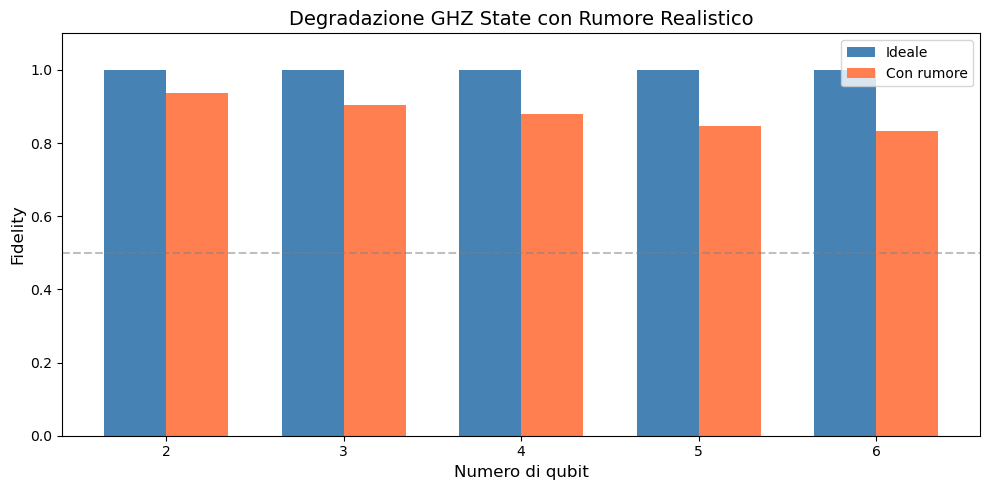

In [14]:
# Grafico
fig, ax = plt.subplots(figsize=(10, 5))

ns = [x[0] for x in ghz_fidelities]
f_ideal = [x[1] for x in ghz_fidelities]
f_noisy = [x[2] for x in ghz_fidelities]

x = np.arange(len(ns))
width = 0.35

bars1 = ax.bar(x - width/2, f_ideal, width, label='Ideale', color='steelblue')
bars2 = ax.bar(x + width/2, f_noisy, width, label='Con rumore', color='coral')

ax.set_xlabel('Numero di qubit', fontsize=12)
ax.set_ylabel('Fidelity', fontsize=12)
ax.set_title('Degradazione GHZ State con Rumore Realistico', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(ns)
ax.legend()
ax.set_ylim(0, 1.1)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random')

plt.tight_layout()
plt.show()

<a id='from_backend'></a>
## 8. Noise Model da Backend Reale

Qiskit Aer puo estrarre automaticamente un noise model da un backend IBM Quantum reale.

In [15]:
# Tentativo di importare noise model da backend IBM
try:
    from qiskit_ibm_runtime import QiskitRuntimeService
    from qiskit_aer.noise import NoiseModel
    
    IBM_AVAILABLE = True
    print("IBM Runtime disponibile")
except ImportError:
    IBM_AVAILABLE = False
    print("IBM Runtime non installato")
    print("  Installa con: pip install qiskit-ibm-runtime")

IBM Runtime disponibile


In [16]:
def get_noise_model_from_backend(backend_name: str = None) -> NoiseModel:
    """
    Estrae un noise model da un backend IBM Quantum reale.
    """
    if not IBM_AVAILABLE:
        print("IBM Runtime non disponibile")
        return None
    
    try:
        service = QiskitRuntimeService()
        
        if backend_name:
            backend = service.backend(backend_name)
        else:
            backend = service.least_busy(operational=True, simulator=False)
        
        print(f"Backend: {backend.name}")
        print(f"  Qubit: {backend.num_qubits}")
        
        # Estrai noise model
        noise_model = NoiseModel.from_backend(backend)
        
        print(f"\nNoise Model estratto:")
        print(f"  Basis gates: {noise_model.basis_gates}")
        
        return noise_model
        
    except Exception as e:
        print(f"Errore: {e}")
        return None

# Per usare questa funzione, decommenta:
# real_noise = get_noise_model_from_backend()

print("Per estrarre noise model da backend reale:")
print("1. Configura credenziali IBM Quantum")
print("2. Decommenta la riga sopra")

Per estrarre noise model da backend reale:
1. Configura credenziali IBM Quantum
2. Decommenta la riga sopra


In [22]:
# Fake backends (simulano hardware reale)
try:
    from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeKyotoV2
    FAKE_AVAILABLE = True
    print("Fake backends disponibili")
except ImportError:
    FAKE_AVAILABLE = False
    print("Fake backends non disponibili")
    print("  Installa con: pip install qiskit-ibm-runtime")

Fake backends non disponibili
  Installa con: pip install qiskit-ibm-runtime


In [29]:
from typing import List, Dict, Tuple, Optional
from qiskit import QuantumCircuit

def list_fake_backends(show_v1: bool = False) -> List[Dict]:
    """Lista tutti i fake backends disponibili."""
    try:
        import qiskit_ibm_runtime.fake_provider as fp
        FAKE_AVAILABLE = True
    except ImportError:
        FAKE_AVAILABLE = False
        print("Installa: pip install qiskit-ibm-runtime")
        return []
    
    backends = []
    for name in sorted(dir(fp)):
        if not name.startswith('Fake') or name.startswith('FakeProvider'):
            continue
        if not show_v1 and not name.endswith('V2'):
            continue
        try:
            backend = getattr(fp, name)()
            backends.append({
                'class': name,
                'name': backend.name,
                'qubits': backend.num_qubits
            })
        except:
            pass
    return backends

def print_fake_backends():
    """Stampa tabella dei fake backends V2 disponibili."""
    backends = list_fake_backends()
    if not backends:
        return
    
    print(f"{'Classe':<25} {'Nome':<20} {'Qubit':>6}")
    print("=" * 55)
    for b in sorted(backends, key=lambda x: x['qubits']):
        print(f"{b['class']:<25} {b['name']:<20} {b['qubits']:>6}")
    print(f"\nTotale: {len(backends)} backends")

def get_fake_backend(name: str = None, min_qubits: int = None, 
                     circuit: QuantumCircuit = None):
    """
    Ottiene un fake backend.
    
    Args:
        name: Nome specifico (es. 'manila', 'kyoto', 'sherbrooke')
        min_qubits: Numero minimo di qubit richiesti
        circuit: Circuito per determinare i qubit necessari
    
    Returns:
        Istanza del fake backend
    
    Examples:
        backend = get_fake_backend('manila')           # FakeManilaV2
        backend = get_fake_backend(min_qubits=10)      # Più piccolo con >= 10 qubit
        backend = get_fake_backend(circuit=my_circuit) # Adatto al circuito
    """
    import qiskit_ibm_runtime.fake_provider as fp
    
    # Se specificato un nome, cerca quello
    if name:
        name_clean = name.lower().replace('fake', '').replace('v2', '')
        for attr in dir(fp):
            if attr.startswith('Fake') and attr.endswith('V2'):
                if name_clean in attr.lower():
                    return getattr(fp, attr)()
        raise ValueError(f"Backend '{name}' non trovato")
    
    # Altrimenti seleziona in base ai qubit
    required = min_qubits or (circuit.num_qubits if circuit else 5)
    
    backends = list_fake_backends()
    suitable = [b for b in backends if b['qubits'] >= required]
    
    if not suitable:
        raise ValueError(f"Nessun backend con >= {required} qubit")
    
    # Prendi il più piccolo adatto
    best = min(suitable, key=lambda x: x['qubits'])
    return getattr(fp, best['class'])()

def run_with_fake_noise(circuit: QuantumCircuit, 
                        backend_name: str = None,
                        shots: int = 4096) -> dict:
    """
    Esegue circuito con noise model da fake backend.
    
    Args:
        circuit: Circuito da eseguire
        backend_name: Nome backend (auto-seleziona se None)
        shots: Numero di shot
    
    Returns:
        Dizionario counts
    """
    from qiskit_aer import AerSimulator
    from qiskit_aer.noise import NoiseModel
    from qiskit_aer.primitives import SamplerV2
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    
    # Ottieni backend
    if backend_name:
        backend = get_fake_backend(backend_name)
    else:
        backend = get_fake_backend(circuit=circuit)
    
    print(f"Backend: {backend.name} ({backend.num_qubits} qubit)")
    
    # Noise model
    noise = NoiseModel.from_backend(backend)
    
    # Transpila
    pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
    transpiled = pm.run(circuit)
    
    # Simula
    sim = AerSimulator(noise_model=noise)
    sampler = SamplerV2()
    sampler._backend = sim
    
    job = sampler.run([transpiled], shots=shots)
    creg = circuit.cregs[0].name if circuit.cregs else 'c'
    
    return job.result()[0].data.__getattribute__(creg).get_counts()


# =============================================================================
# TEST
# =============================================================================
if __name__ == "__main__":
    FAKE_AVAILABLE = True
    # Lista backends
    print("FAKE BACKENDS DISPONIBILI:")
    print_fake_backends()
    
    print("\n" + "="*55 + "\n")
    
    # Test selezione
    print("TEST SELEZIONE:")
    print(f"  get_fake_backend('manila'): {get_fake_backend('manila').name}")
    print(f"  get_fake_backend(min_qubits=20): {get_fake_backend(min_qubits=20).name}")
    
    # Test con circuito
    qc = QuantumCircuit(3, 3)
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.measure([0,1,2], [0,1,2])
    
    print(f"\n  Circuito GHZ a 3 qubit:")
    print(f"  get_fake_backend(circuit=qc): {get_fake_backend(circuit=qc).name}")
    
    print("\n" + "="*55 + "\n")
    
    # Test esecuzione
    print("TEST ESECUZIONE CON RUMORE:")
    counts = run_with_fake_noise(qc)
    print(f"  Counts: {counts}")
    
    total = sum(counts.values())
    fidelity = (counts.get('000', 0) + counts.get('111', 0)) / total
    print(f"  Fidelity: {fidelity:.4f}")


FAKE BACKENDS DISPONIBILI:
Classe                    Nome                  Qubit
FakeArmonkV2              fake_armonk               1
FakeAthensV2              fake_athens               5
FakeBelemV2               fake_belem                5
FakeBogotaV2              fake_bogota               5
FakeBurlingtonV2          fake_burlington           5
FakeEssexV2               fake_essex                5
FakeLimaV2                fake_lima                 5
FakeLondonV2              fake_london               5
FakeManilaV2              fake_manila               5
FakeOurenseV2             fake_ourense              5
FakeQuitoV2               fake_quito                5
FakeRomeV2                fake_rome                 5
FakeSantiagoV2            fake_santiago             5
FakeValenciaV2            fake_valencia             5
FakeVigoV2                fake_vigo                 5
FakeYorktownV2            fake_yorktown             5
FakeCasablancaV2          fake_casablanca           7
F

In [30]:
print(FAKE_AVAILABLE)
if FAKE_AVAILABLE:
    # Use a fake backend (5 qubit) as an example
    fake_backend = get_fake_backend(min_qubits=5)
    
    print(f"Fake Backend: {fake_backend.name}")
    print(f"  Qubit: {fake_backend.num_qubits}")
    
    # Extract noise model
    fake_noise = NoiseModel.from_backend(fake_backend)
    print(f"  Basis gates: {fake_noise.basis_gates}")
    
    # Test Bell state cwith  fake noise
    sim_fake = AerSimulator(noise_model=fake_noise)
    sampler_fake = SamplerV2()
    sampler_fake._backend = sim_fake
    
    # Transpile the backend
    pm = generate_preset_pass_manager(optimization_level=1, backend=fake_backend)
    bell_transpiled = pm.run(qc_bell)
    
    job = sampler_fake.run([bell_transpiled], shots=4096)
    counts_fake = job.result()[0].data.c.get_counts()
    
    print(f"\nBell state con FakeManila noise:")
    print(f"  Counts: {counts_fake}")
    
    correct = counts_fake.get('00', 0) + counts_fake.get('11', 0)
    fidelity = correct / sum(counts_fake.values())
    print(f"  Fidelity: {fidelity:.4f}")

True
Fake Backend: fake_athens
  Qubit: 5
  Basis gates: ['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']

Bell state con FakeManila noise:
  Counts: {'00': 1941, '11': 2028, '01': 66, '10': 61}
  Fidelity: 0.9690


<a id='grover'></a>
## 9. Caso Studio: Algoritmo di Grover

Analizziamo come il rumore influenza l'algoritmo di Grover.

In [19]:
def grover_circuit(n_qubits: int, marked_state: str) -> QuantumCircuit:
    """
    Costruisce circuito Grover per cercare uno stato marcato.
    """
    qc = QuantumCircuit(n_qubits, n_qubits)
    
    # Numero ottimale di iterazioni
    n_iterations = int(np.pi / 4 * np.sqrt(2**n_qubits))
    
    # Superposizione iniziale
    qc.h(range(n_qubits))
    qc.barrier()
    
    for _ in range(n_iterations):
        # Oracle: inverte fase dello stato marcato
        for i, bit in enumerate(reversed(marked_state)):
            if bit == '0':
                qc.x(i)
        
        # Multi-controlled Z
        if n_qubits == 2:
            qc.cz(0, 1)
        elif n_qubits == 3:
            qc.ccz(0, 1, 2)
        else:
            qc.h(n_qubits - 1)
            qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
            qc.h(n_qubits - 1)
        
        for i, bit in enumerate(reversed(marked_state)):
            if bit == '0':
                qc.x(i)
        
        qc.barrier()
        
        # Diffusore
        qc.h(range(n_qubits))
        qc.x(range(n_qubits))
        
        if n_qubits == 2:
            qc.cz(0, 1)
        elif n_qubits == 3:
            qc.ccz(0, 1, 2)
        else:
            qc.h(n_qubits - 1)
            qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
            qc.h(n_qubits - 1)
        
        qc.x(range(n_qubits))
        qc.h(range(n_qubits))
        qc.barrier()
    
    qc.measure(range(n_qubits), range(n_qubits))
    
    return qc

# Grover per 3 qubit, cerca '101'
grover_3q = grover_circuit(3, '101')
print(f"Grover (3 qubit, target='101'):")
print(f"  Profondita: {grover_3q.depth()}")
print(f"  Gate: {grover_3q.size()}")

Grover (3 qubit, target='101'):
  Profondita: 18
  Gate: 38


In [20]:
# Confronto Grover: ideale vs diversi livelli di rumore
def analyze_grover_noise(circuit: QuantumCircuit, target: str,
                         noise_levels: List[float]) -> dict:
    """
    Analizza Grover con diversi livelli di rumore.
    """
    results = {'noise': [], 'success_prob': [], 'fidelity': []}
    
    for p in noise_levels:
        if p == 0:
            # Ideale
            sim = AerSimulator()
        else:
            noise = create_realistic_noise_model(
                t1=100e3, t2=80e3,
                p_depol_1q=p/10, p_depol_2q=p,
                p_readout_0=p/2, p_readout_1=p
            )
            sim = AerSimulator(noise_model=noise)
        
        sampler = SamplerV2()
        if p > 0:
            sampler._backend = sim
        
        job = sampler.run([circuit], shots=4096)
        counts = job.result()[0].data.c.get_counts()
        
        total = sum(counts.values())
        success = counts.get(target, 0) / total
        
        results['noise'].append(p)
        results['success_prob'].append(success)
    
    return results

# Analisi
noise_levels = [0, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
grover_results = analyze_grover_noise(grover_3q, '101', noise_levels)

print("Grover (3 qubit): Successo vs Rumore")
print("=" * 40)
print(f"{'Rumore (2q)':<15} {'P(success)':<15}")
print("-" * 30)
for p, s in zip(grover_results['noise'], grover_results['success_prob']):
    print(f"{p:<15.3f} {s:<15.4f}")

Grover (3 qubit): Successo vs Rumore
Rumore (2q)     P(success)     
------------------------------
0.000           0.9502         
0.001           0.9270         
0.005           0.9255         
0.010           0.8904         
0.020           0.8557         
0.050           0.7549         
0.100           0.6118         


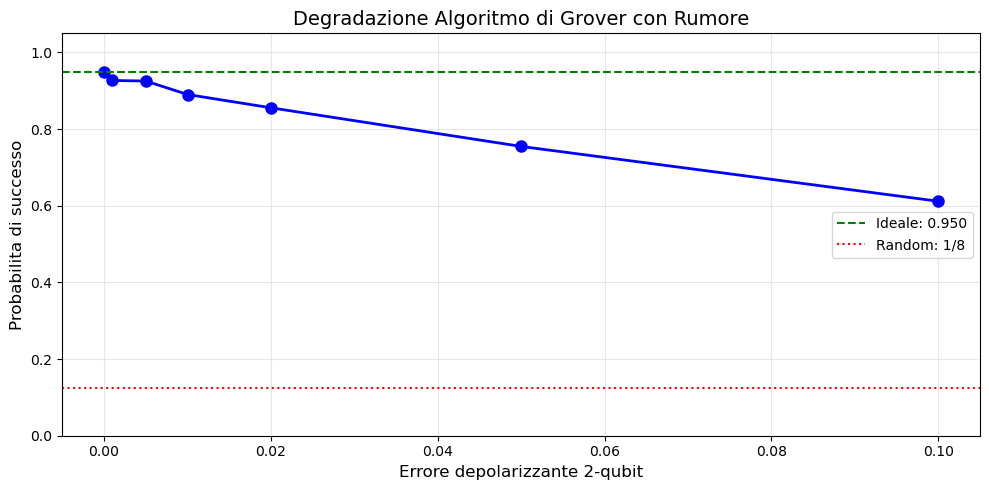

In [21]:
# Grafico
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(grover_results['noise'], grover_results['success_prob'], 
        'bo-', linewidth=2, markersize=8)

# Linea teorica per caso ideale
ax.axhline(y=grover_results['success_prob'][0], color='g', linestyle='--', 
           label=f'Ideale: {grover_results["success_prob"][0]:.3f}')

# Soglia random
ax.axhline(y=1/8, color='r', linestyle=':', label='Random: 1/8')

ax.set_xlabel('Errore depolarizzante 2-qubit', fontsize=12)
ax.set_ylabel('Probabilita di successo', fontsize=12)
ax.set_title('Degradazione Algoritmo di Grover con Rumore', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

<a id='exercises'></a>
## 10. Esercizi

### Esercizio 1: Confronto Errori (Facile)
Crea noise model con solo errori di gate, solo errori di readout, e combinati. Confronta l'effetto su un Bell state.

### Esercizio 2: Soglia di Rumore (Medio)
Per l'algoritmo di Grover a 4 qubit, trova la soglia di rumore oltre la quale la probabilita di successo scende sotto il 50%.

### Esercizio 3: T1 vs T2 (Avanzato)
Studia separatamente l'effetto di T1 e T2 su una superposizione |+>. Quale parametro e piu critico?

In [ ]:
# Spazio per esercizi

# Es 1: Confronto errori
# noise_gate_only = NoiseModel()
# noise_readout_only = NoiseModel()
# ...

# Es 2: Soglia Grover
# grover_4q = grover_circuit(4, '1010')
# ...

## Riferimenti

1. **Nielsen & Chuang** (2000). *Quantum Computation and Quantum Information*. Chapter 8: Quantum Noise.

2. **Preskill** (1998). *Lecture Notes on Quantum Computation*. Chapter 3: Quantum Noise.

3. [Qiskit Aer Documentation](https://qiskit.github.io/qiskit-aer/)

4. [IBM Quantum Documentation - Errors](https://docs.quantum.ibm.com/)

---

**Course**: Quantum Computing Laboratory  
**Version**: 2.2.0  
**License**: MIT